In [ ]:
import matplotlib.pyplot as plt
#%matplotlib inline
import cv2
import numpy as np
import exifread
import glob, os
import shutil
from sklearn import decomposition
import sklearn 
import time
%matplotlib inline


In [43]:
a=np.fabs(np.arange(10))
print np.where((a>6) | (a<8))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),)


In [157]:
def sliceim(im):
    xdim, ydim=np.shape(im)
    im=im-np.median(im)
    numslice=8
    dx=xdim/numslice
    dy=ydim/numslice
    mean=[]
    for i in range(numslice-1):
        for j in range(numslice-1):
            imslice=im[dx*i:dx*(i+1),dy*j:dy*(j+1)]
            mean=np.append(mean,np.std(imslice))
    p16=np.percentile(mean,16)
    med=np.median(mean)
    if np.max(mean) > med+5*(med-p16):
        return True

In [163]:
#listname=['SM-5_SB-8_20150406']
memory='SM-1_SB-1_20141226'
start_time = time.time()

#for memory in listname:
files = glob.glob("/Users/Mehdi/Downloads/GoldenGate-Animals/"+memory+"/Negatives/*.JPG")

numneg=len(files)
print numneg
files = files+glob.glob("/Users/Mehdi/Downloads/GoldenGate-Animals/"+memory+"/Positives/*.JPG")
num=len(files)
print num

direc='/Users/Mehdi/Downloads/GoldenGate-Animals/'+memory+'/PCA/'
lenad=len('/Users/Mehdi/Downloads/GoldenGate-Animals/'+memory+'/')





#start_time = time.time()
nightname_all=direc[0:-4]+'Night.txt'
allnight=open(nightname_all,'w')
allcandid=direc[0:-4]+'allcandid.txt'
allday=open(allcandid,'w')


name=direc
if os.path.isdir(name):
    shutil.rmtree(name)
if os.path.isdir(direc)== False:
    os.mkdir(direc)    
#os.mkdir(name)
sx=1840
sy=2592
dx=sx/5
dy=sy/5
imcube=np.zeros([368, 518])
# To distinguish between photos taken during the day and night time.
daynight=np.zeros(len(files))


#clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
print 'Reading images, Down sampling and converting to Grayscale '
for i in range(len(files)):
    im=cv2.imread(files[i])
    if (np.max(im[500:520,500:520,0]-im[500:520,500:520,1]!=0)):
        daynight[i]=1
        im[1744:1944,0:209,:]=0
        im=im[0:1840,:,:]
        #im[1840:1944,:,:]=0
        img=cv2.resize(im, (dy, dx),interpolation=cv2.INTER_NEAREST)
        imresized=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        #imresized = clahe.apply(imresized)
        imcube=np.dstack((imcube,imresized))

# Saving the list of night time images
indnight=np.where(daynight == 0)[0]
imlistblur_n= np.array(files)[indnight]
nightname=name+'Night.txt'
night=open(nightname,'w')
for i in imlistblur_n:
    night.write(i+'\n')
    allnight.write(i+'\n')
night.close()

if (len(np.shape(imcube))>2) | (np.max(imcube)>0):
    imcube=np.delete(imcube,0,2)
    numdayphoto=len(imcube[0,0,:])
    print 'Bluring images...'
    imblur=np.empty([368,518])
    for i in range(numdayphoto):
        imblur=np.dstack((imblur,cv2.blur(imcube[:,:,i],(5,5))))
    imblur=np.delete(imblur,0,2)

    #Calculating the mean blur image
    nx,ny,nz=np.shape(imblur)
    blurmean=np.mean(imblur,axis=2)
    imblur_center=np.zeros([nx*ny,nz])
    np.shape(imblur)
    for i in range(numdayphoto):
        imblur_center[:,i]=(imblur[:,:,i]-blurmean).flatten()
    print 'Finding the 10 most important principle axis and each image components'
    n_components=10
    estimator=decomposition.PCA(n_components=n_components, svd_solver='randomized',whiten=True)
    estimator.fit(imblur_center.T)

    blur_transformed=estimator.fit_transform(imblur_center.T)
    blur_inverse=estimator.inverse_transform(blur_transformed)

    ### calculating the similarity between the PCA blured inverse transformed image and the original image.
    stdpcablur=[]
    medianpcablur=[]
    sliceimout=np.zeros(numdayphoto,dtype=bool)
    for i in range(numdayphoto):
        invblur=blur_inverse[i,:].reshape(368, 518)
        imres=imblur_center[:,i].reshape(368, 518)-invblur
        stdpcablur=np.append(stdpcablur,np.std(imres))
        medianpcablur=np.append(medianpcablur,np.mean(imblur_center[:,i].reshape(368, 518)-invblur))
        sliceimout[i]=sliceim(imres)
    # Plotting the distribution of stddev of the residual maps
    plt.figure()
    minstdblur=np.min(stdpcablur)
    maxstdblur=np.max(stdpcablur)

    n, bins, patches=plt.hist(stdpcablur/maxstdblur,bins=np.linspace(minstdblur/maxstdblur,1,70),facecolor='red', hatch='///',alpha=1.0,label='Daylight')#=' Lon:'+lon[id0][0][1:-1]+'\n Lat:'+lat[id0][0][1:-1]+'\n Daylight')
    minmedianblur=np.min(medianpcablur)
    medianmaxblur=np.max(medianpcablur)

    stdpcablur_med=np.median(stdpcablur/maxstdblur)
    stdpcablur_16=np.percentile(stdpcablur/maxstdblur,16)
    sigma=stdpcablur_med-stdpcablur_16
    newthr=stdpcablur_med+2*sigma
    xmin=np.min(stdpcablur/maxstdblur)


    plt.axis([xmin, np.max([1,newthr+0.02]), 0, np.max(n)+5])
    #plt.grid(True)
    plt.xlabel('Normalized PCA Dissimilarity Score')
    plt.ylabel('Number of images')
    plt.title('All Dates')
    plt.plot([newthr,newthr],[0,np.max(n)+5],linewidth=2,color='blue',label=r'3\sigma')

    right=np.ones(np.max(n)+5)-0.5
    plt.hist(right,bins=np.linspace(newthr,np.max([1,newthr+0.02]),2),facecolor='green', alpha=0.4)
    left=np.ones(np.max(n)+5)-0.8
    plt.hist(left,bins=np.linspace(0,newthr,2),facecolor='cyan', alpha=0.4)
    plotname=name+'PCA-Dissimilarity.png'
    plt.savefig(plotname)
    plt.close()
    # Saving the list of outlier candidates
    indday=np.where(daynight == 1)[0]
    imlistblur= np.array(files)[indday]

    #out2sigma=np.where((stdpcablur/maxstdblur >= newthr)|(sliceimout == True))[0]
    out2sigma=np.where(sliceimout == True)[0]
    # Fill in the blanks between the out2sigma IDs that might have been missed
    if (len(out2sigma) > 0):
        if  out2sigma[0] > 0:
            np.insert(out2sigma,0,out2sigma[0]-1)
        if  out2sigma[-1] < len(imlistblur)-1:
            out2sigma=np.append(out2sigma,out2sigma[-1]+1)
        arr2=out2sigma[1:]-out2sigma[0:-1]
        id=np.where(arr2 != 1)[0]
        if len(id) > 0:
            out2sigma=np.insert(out2sigma,id+1,out2sigma[id]+1)

        newname=name+'Outliers.txt'
        cand=open(newname,'w')
        for i in imlistblur[out2sigma]:
            cand.write(i+'\n')
            allday.write(i+'\n')

        cand.close()

        # Saving the std of residuals in a textfile
        resdata=name+'STD-Res.txt'
        res=open(resdata,'w')
        for i in range(len(imlistblur)):
            res.write(imlistblur[i]+'    '+str(stdpcablur[i])+'\n')
        res.close()

        # Saving the PCA residual maps
        print 'saving the PCA residual maps' 
        for i in range(len(out2sigma)):
            newname=name+imlistblur[out2sigma][i][lenad:lenad+1]+'_'+imlistblur[out2sigma][i][lenad+10:-4]
            invblur=blur_inverse[out2sigma,:][i].reshape(368, 518)
            #cv2.imwrite(newname+'_PCA_InvTransformed.JPG',invblur+blurmean)
            #cv2.imwrite(newname+'_PCA_MeanSubOrg.JPG',imblur_center[:,i].reshape(368, 518)+blurmean)
            imres=imblur_center[:,out2sigma[i]].reshape(368, 518)-invblur
            imres=imres+np.fabs(np.min(imres))
            imres=255*imres/np.max(imres)
            cv2.imwrite(newname+'_PCA_Residual.JPG',imres)

    if (len(out2sigma) <=5) & (len(indday) <= 50):
        print 'Low sample size! Outputing all the original images...'
        allname=name+'all.txt'
        allim=open(allname,'w')
        for i in range(len(indday)):
            orgname=name+imlistblur[i][lenad:lenad+1]+'_'+imlistblur[i][lenad+10:-4]
            cv2.imwrite(orgname+'.JPG',imcube[:,:,i])
            allim.write(imlistblur[i]+'\n')
            allday.write(imlistblur[i]+'\n')
        allim.close()
allnight.close()
allday.close()

print("--- %s seconds ---" % (time.time() - start_time))

3652
3744
Reading images, Down sampling and converting to Grayscale 
Bluring images...
Finding the 10 most important principle axis and each image components
saving the PCA residual maps
--- 25137.842067 seconds ---


In [162]:

print sliceimout

[False False False ...,  True False False]


3.53609985676


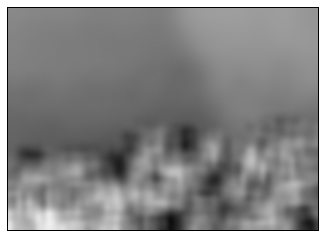

3.46151533868


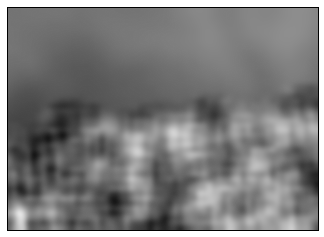

2.71536527712


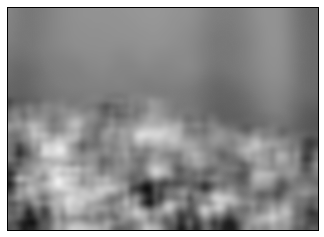

1.94407620652


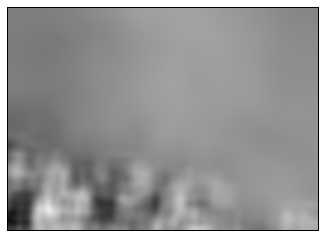

1.24035432688


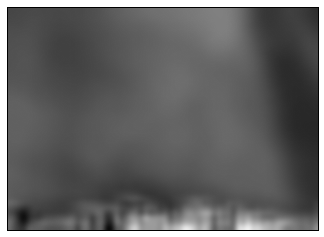

1.98476961639


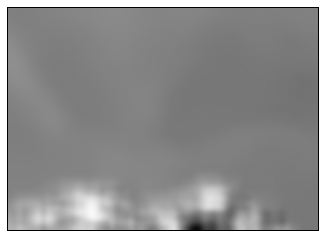

1.50689577794


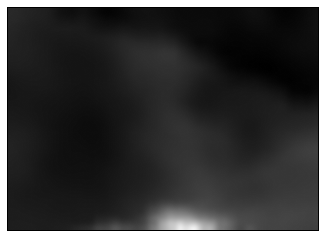

4.850702199


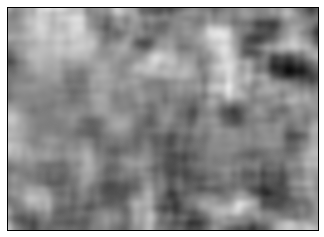

5.73020547555


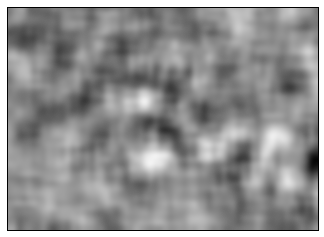

6.05071021288


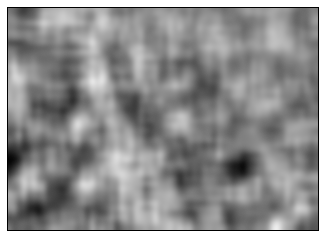

3.77842722183


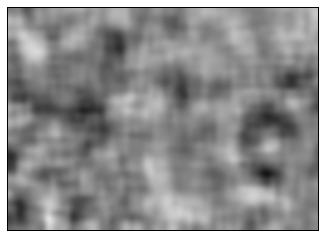

4.05466354543


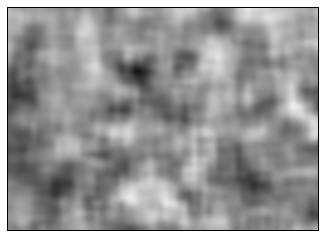

4.19763800943


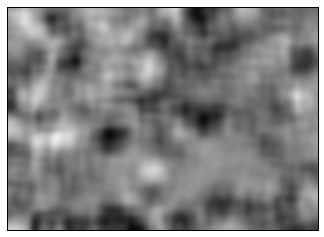

4.20687629912


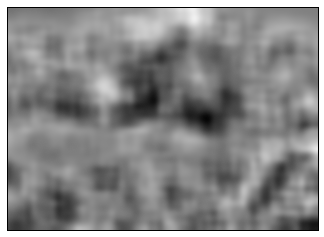

6.95328964787


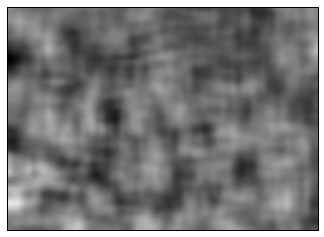

5.58241035893


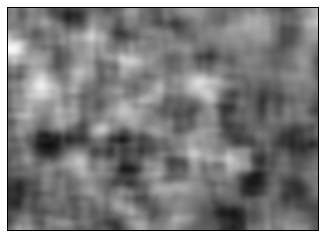

4.28703657299


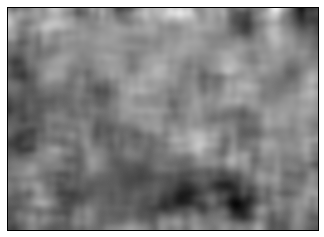

4.2146263464


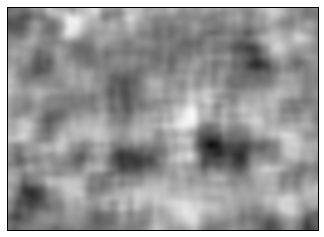

3.78234082636


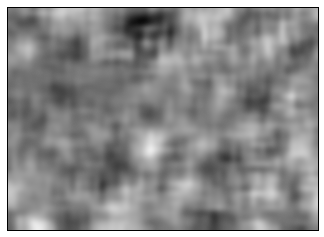

5.75455515243


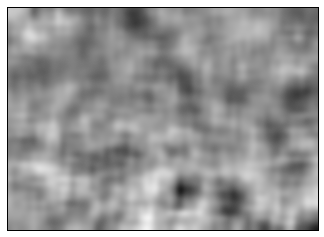

5.69090013827


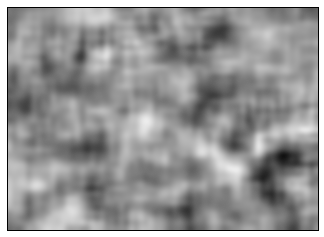

8.49179731208


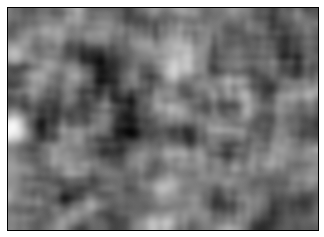

6.55244810691


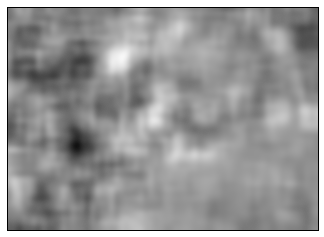

5.03842490396


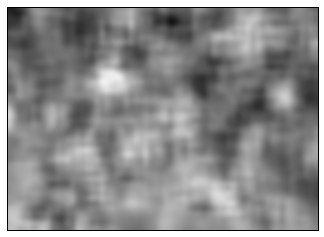

10.6429178162


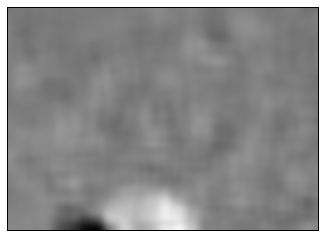

6.80059857394


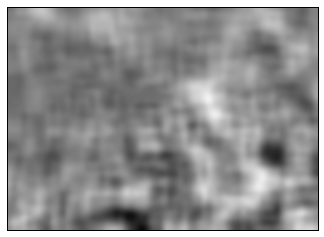

7.81766272598


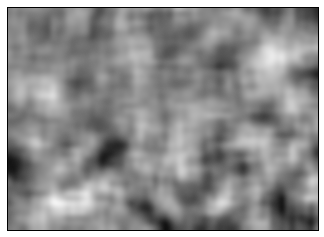

8.48247631057


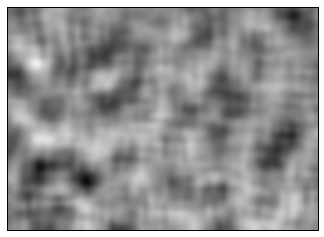

8.47390674146


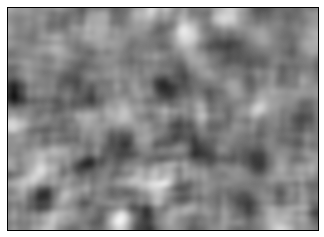

5.39249796451


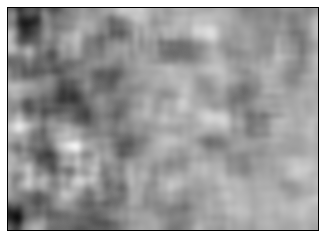

26.6736597214


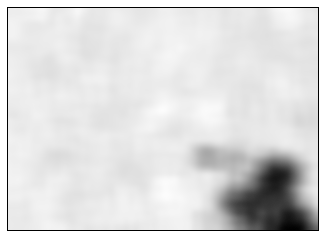

41.0324394433


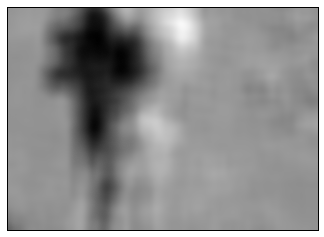

7.90169762636


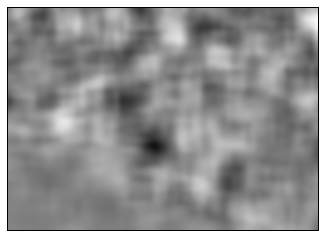

10.2331970195


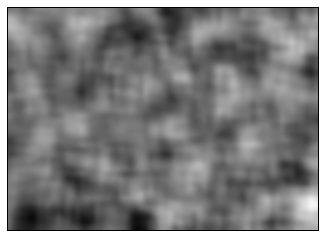

11.1252872233


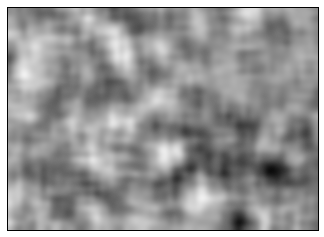

9.51632122819


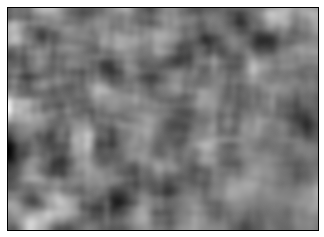

5.79672167637


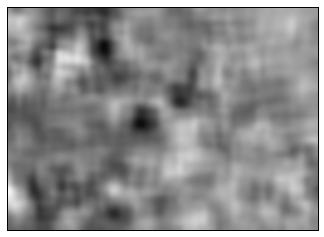

21.3386919698


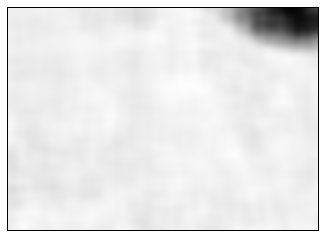

16.1984446738


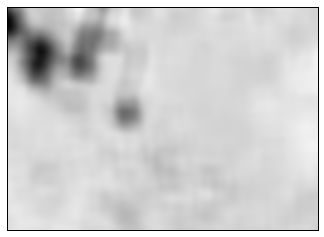

11.1600021076


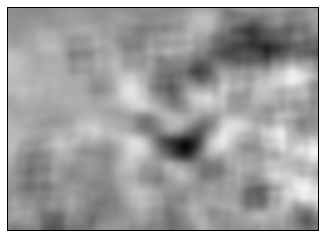

12.4379111763


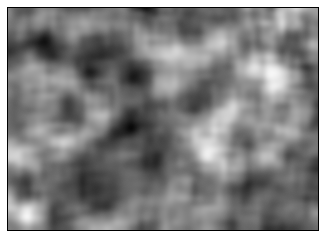

13.418729172


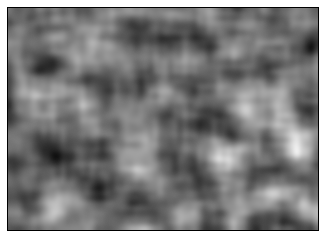

7.43279923229


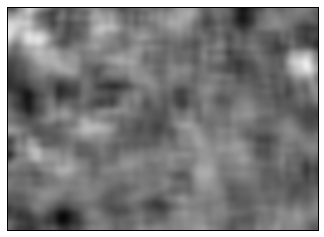

6.50951405135


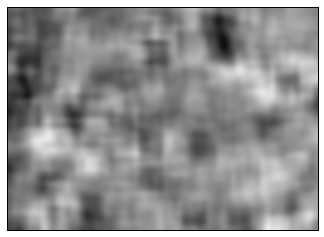

5.80199272692


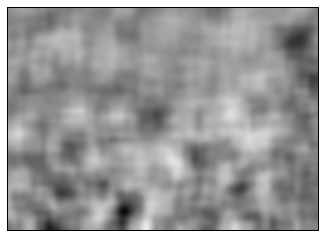

7.95982131633


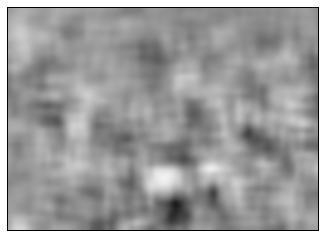

7.37315343645


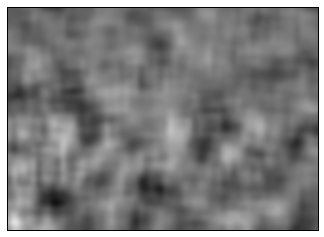

8.40834681962


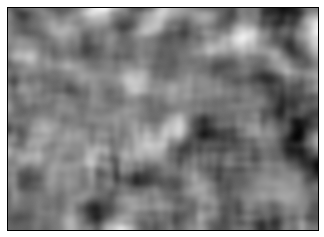

13.704145262


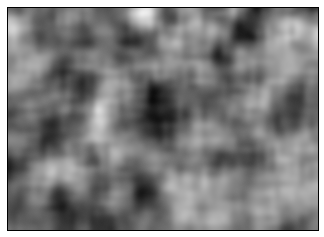

True


In [151]:
%matplotlib inline
np.shape(imres)
im=imres
xdim, ydim=np.shape(im)
im=im-np.median(im)
numslice=8
dx=xdim/numslice
dy=ydim/numslice
mean=[]
for i in range(numslice-1):
    for j in range(numslice-1):
        imslice=im[dx*i:dx*(i+1),dy*j:dy*(j+1)]
        print np.std(imslice)
        plt.xticks([]), plt.yticks([])
        plt.imshow(imslice,cmap='gray',interpolation = 'bicubic')
        plt.show()
        mean=np.append(mean,np.std(imslice))
p16=np.percentile(mean,16)
med=np.median(mean)
if np.max(mean) > med+5*(med-p16):
    print True

3.78108847291
6.50951405135
(49,)


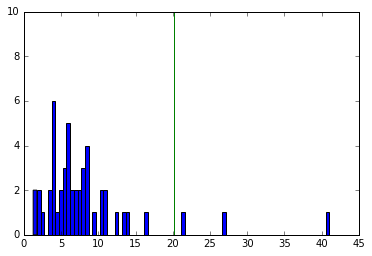

In [149]:
%matplotlib inline
plt.hist(mean,bins=80)
plt.plot([med+5*(med-p16),med+5*(med-p16)],[0,10])
print p16
print med
print np.shape(mean)

(46, 64)


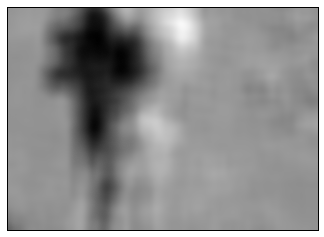

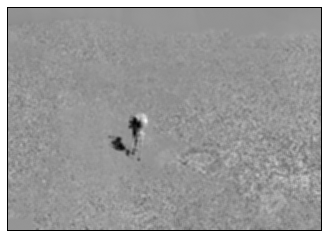

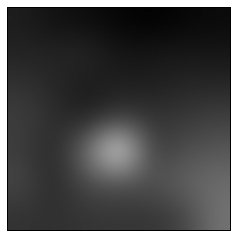

In [136]:
i=4
j=3
print np.shape(imres[dx*i:dx*(i+1),dy*j:dy*(j+1)])
plt.xticks([]), plt.yticks([])
plt.imshow(imres[dx*i:dx*(i+1),dy*j:dy*(j+1)],cmap='gray',interpolation = 'bicubic')
plt.show()
plt.xticks([]), plt.yticks([])
plt.imshow(imres,cmap='gray',interpolation = 'bicubic')
plt.show()
plt.xticks([]), plt.yticks([])
plt.imshow(mean.reshape(numslice-1,numslice-1),cmap='gray',interpolation = 'bicubic')
plt.show()